📊 Notebook 1 - Análise Exploratória Focada em Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuração inicial dos gráficos
plt.style.use('default')
sns.set_palette("husl")

print("Projeto: Sistema de Manutenção Preditiva")
print("="*60)

# Carregar dados
df = pd.read_csv('../data/bootcamp_train.csv')
print(f"Dataset carregado com {df.shape[0]:,} amostras e {df.shape[1]} colunas.")

Projeto: Sistema de Manutenção Preditiva
Dataset carregado com 35,260 amostras e 15 colunas.


In [2]:
# ===== 1. Visão inicial dos dados =====
print("\n[1] Primeira olhada nos dados")
print("-"*40)

print("Tipos de dados:")
print(df.dtypes)
print(f"\nValores faltantes: {df.isnull().sum().sum()}")

print("\nDistribuição dos tipos de máquinas:")
print(df['tipo'].value_counts())

print("\nEstatísticas básicas dos sensores:")
sensor_cols = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa',
               'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
print(df[sensor_cols].describe().round(2))


[1] Primeira olhada nos dados
----------------------------------------
Tipos de dados:
id                                   int64
id_produto                          object
tipo                                object
temperatura_ar                     float64
temperatura_processo               float64
umidade_relativa                   float64
velocidade_rotacional              float64
torque                             float64
desgaste_da_ferramenta             float64
falha_maquina                       object
FDF (Falha Desgaste Ferramenta)     object
FDC (Falha Dissipacao Calor)        object
FP (Falha Potencia)                 object
FTE (Falha Tensao Excessiva)          bool
FA (Falha Aleatoria)                object
dtype: object

Valores faltantes: 3541

Distribuição dos tipos de máquinas:
tipo
L    23855
M     8799
H     2606
Name: count, dtype: int64

Estatísticas básicas dos sensores:
       temperatura_ar  temperatura_processo  umidade_relativa  \
count        34644.00     


[2] Frequência de falhas
----------------------------------------
Distribuição das classes de falha:


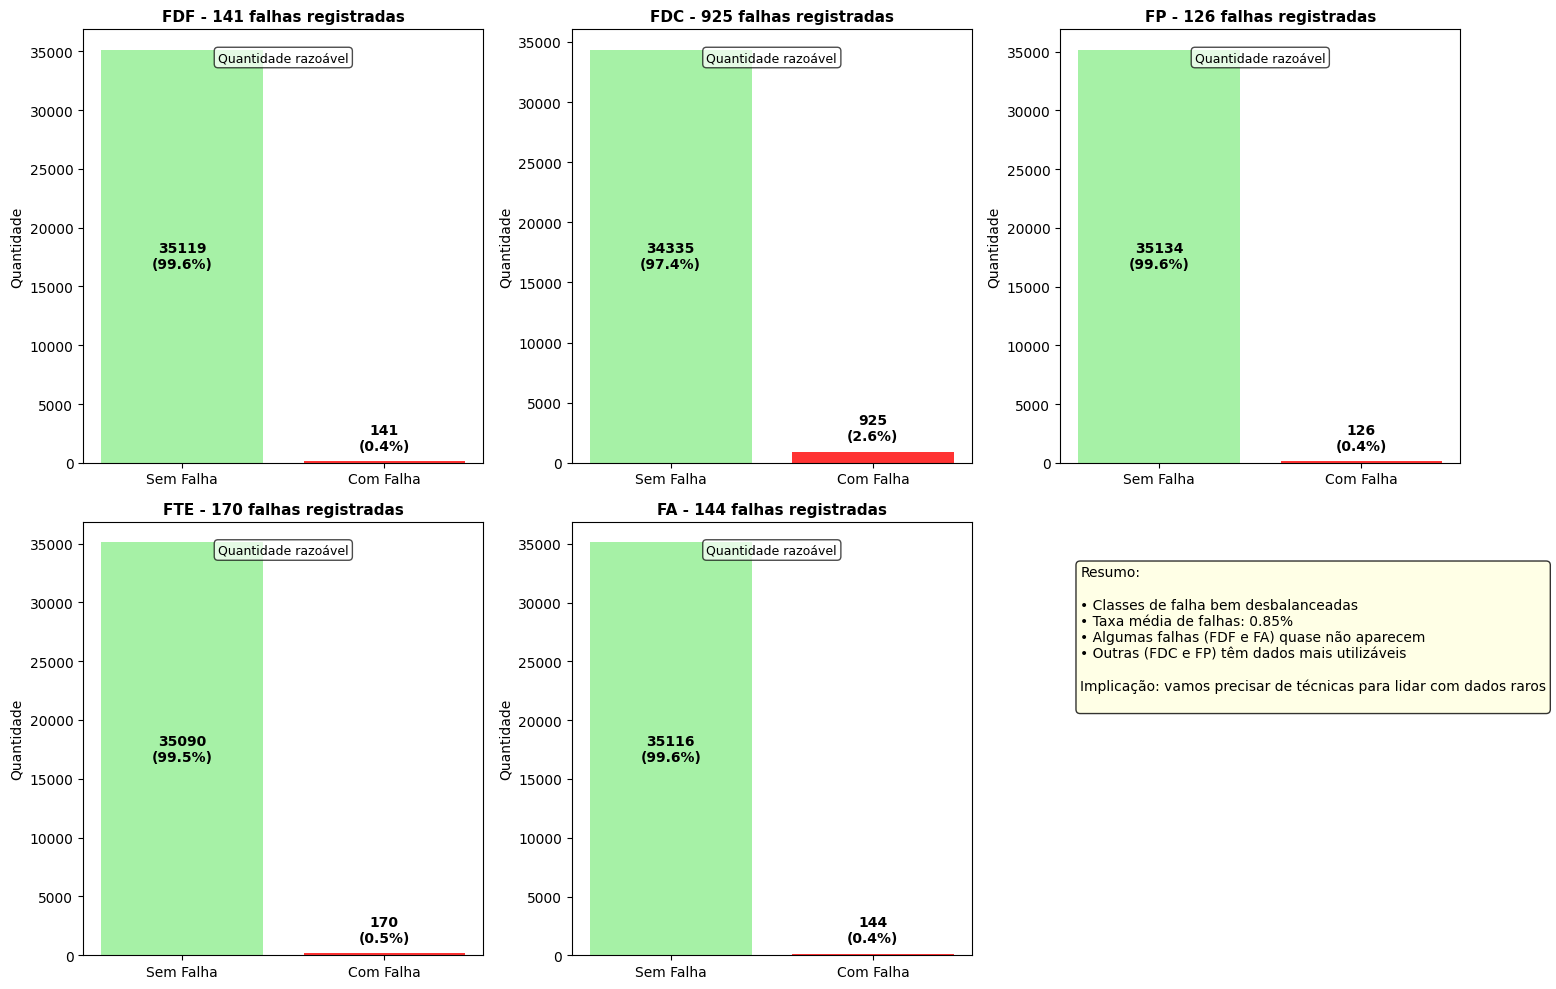


Observações:
1. As falhas são bem raras → problema de classificação difícil.
2. Precisamos priorizar recall (detecção das falhas), mesmo aceitando alguns falsos positivos.


In [3]:
# ===== 2. Distribuição das falhas =====
print("\n[2] Frequência de falhas")
print("-"*40)

failure_cols = [
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)', 
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

def limpar_rotulo(valor):
    """Normaliza os rótulos em 0/1"""
    valor_str = str(valor).lower().strip()
    if valor_str in ['não', 'n', 'false', '0', 'nan']:
        return 0
    else:
        return 1

# Normalizando colunas de falha
for col in failure_cols:
    df[col] = df[col].apply(limpar_rotulo)

failure_names = ['FDF', 'FDC', 'FP', 'FTE', 'FA']

# Visualização
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

print("Distribuição das classes de falha:")

for i, (col, name) in enumerate(zip(failure_cols, failure_names)):
    if i < 5:
        # força ordem 0/1
        counts = df[col].value_counts().reindex([0, 1], fill_value=0)  
        total = len(df)

        # Gráfico
        bars = axes[i].bar(['Sem Falha', 'Com Falha'], counts, 
                           color=['lightgreen', 'red'], alpha=0.8)
        
        # Percentuais nas barras
        for j, (bar, count) in enumerate(zip(bars, counts)):
            pct = count / total * 100
            if j == 0:  # Sem falha → escreve dentro da barra
                axes[i].text(bar.get_x() + bar.get_width()/2., 
                             bar.get_height() * 0.5,
                             f'{count}\n({pct:.1f}%)',
                             ha='center', va='center', fontweight='bold', color='black')
            else:  # Com falha → escreve acima da barra
                axes[i].text(bar.get_x() + bar.get_width()/2., 
                             bar.get_height() + max(counts)*0.02,
                             f'{count}\n({pct:.1f}%)',
                             ha='center', va='bottom', fontweight='bold', color='black')
        
        axes[i].set_title(f'{name} - {counts[1]} falhas registradas', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Quantidade')

        # Status visual
        if counts[1] < 20:
            status = "Poucos casos"
        elif counts[1] < 50:
            status = "Amostra limitada"
        else:
            status = "Quantidade razoável"
        
        axes[i].text(0.5, 0.95, status, transform=axes[i].transAxes, 
                    ha='center', va='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Resumo no último subplot
axes[5].axis('off')
summary_text = "Resumo:\n\n"
summary_text += "• Classes de falha bem desbalanceadas\n"
summary_text += f"• Taxa média de falhas: {np.mean([df[col].sum()/len(df) for col in failure_cols])*100:.2f}%\n"
summary_text += "• Algumas falhas (FDF e FA) quase não aparecem\n"
summary_text += "• Outras (FDC e FP) têm dados mais utilizáveis\n\n"
summary_text += "Implicação: vamos precisar de técnicas para lidar com dados raros\n"

axes[5].text(0.05, 0.9, summary_text, transform=axes[5].transAxes,
            fontsize=10, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nObservações:")
print("1. As falhas são bem raras → problema de classificação difícil.")
print("2. Precisamos priorizar recall (detecção das falhas), mesmo aceitando alguns falsos positivos.")


[3] Relação entre sensores
----------------------------------------


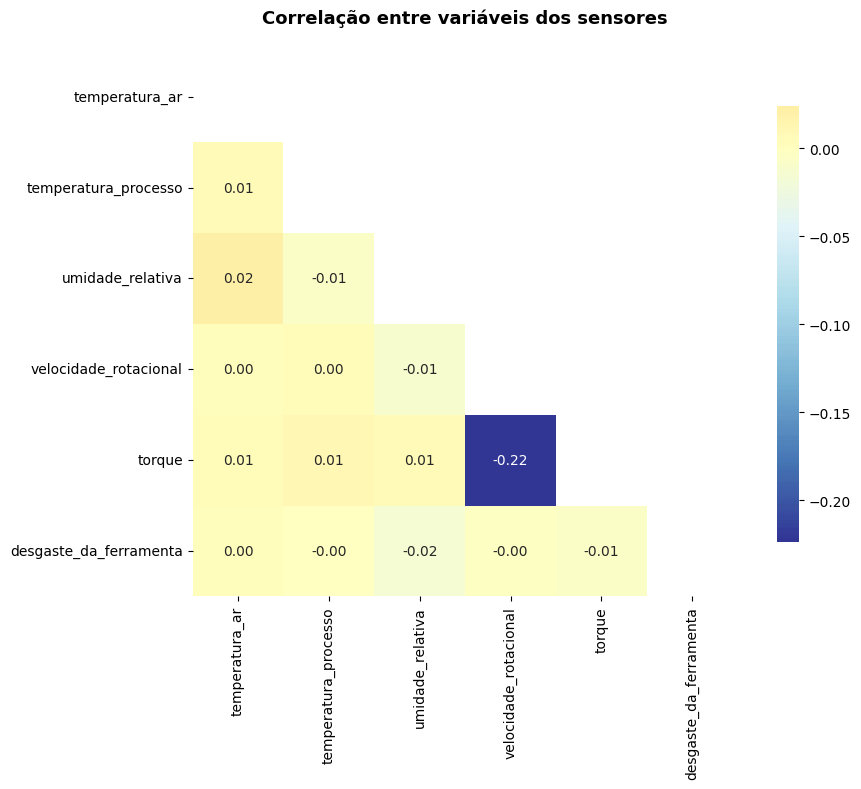

Correlações relevantes encontradas:
Nenhuma correlação acima de 0.3 encontrada.


In [4]:
# ===== 3. Correlação entre sensores =====
print("\n[3] Relação entre sensores")
print("-"*40)

plt.figure(figsize=(10, 8))
corr_matrix = df[sensor_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
    center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8}
)

plt.title('Correlação entre variáveis dos sensores', fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Correlações relevantes encontradas:")
found = False
for i in range(len(sensor_cols)):
    for j in range(i+1, len(sensor_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"- {sensor_cols[i]} ↔ {sensor_cols[j]}: {corr_val:.2f}")
            found = True

if not found:
    print("Nenhuma correlação acima de 0.3 encontrada.")


[4] Sensores x tipos de falha
----------------------------------------
Focando nos tipos com mais ocorrências: FTE, FDC

Analisando FTE:
  - temperatura_processo: normal=34493, com falha=168
  - torque: normal=34469, com falha=168
     Diferença média de 41.3%
  - velocidade_rotacional: normal=34351, com falha=158
     Diferença média de 10.0%

Analisando FDC:
  - temperatura_processo: normal=33750, com falha=911
  - torque: normal=33729, com falha=908
  - velocidade_rotacional: normal=33611, com falha=898


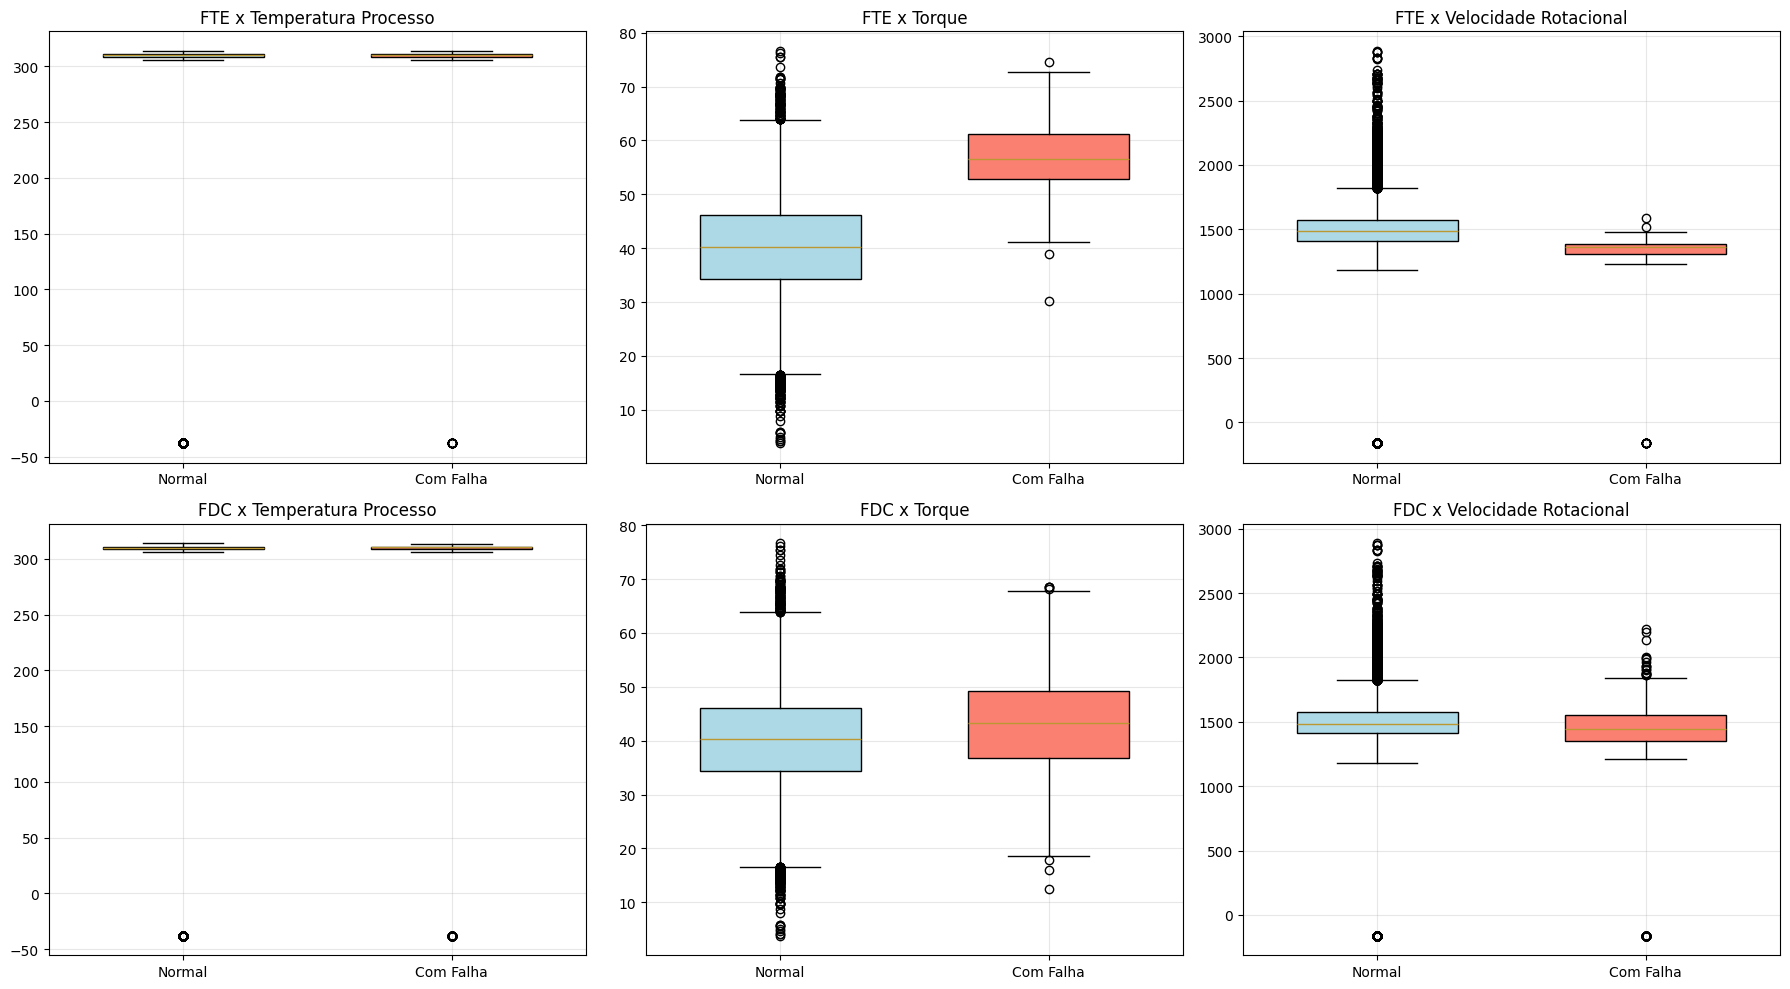

In [5]:
# ===== 4. Relação entre sensores e falhas =====
print("\n[4] Sensores x tipos de falha")
print("-"*40)

failure_counts = [df[col].sum() for col in failure_cols]
top_2_indices = np.argsort(failure_counts)[-2:]
top_2_names = [failure_names[i] for i in top_2_indices]
top_2_cols = [failure_cols[i] for i in top_2_indices]

print(f"Focando nos tipos com mais ocorrências: {', '.join(top_2_names)}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
key_sensors = ['temperatura_processo', 'torque', 'velocidade_rotacional']

for row, (failure_col, failure_name) in enumerate(zip(top_2_cols, top_2_names)):
    print(f"\nAnalisando {failure_name}:")
    
    for col, sensor in enumerate(key_sensors):
        ax = axes[row, col]

        sem_falha = df[df[failure_col] == 0][sensor].dropna()
        com_falha = df[df[failure_col] == 1][sensor].dropna()

        print(f"  - {sensor}: normal={len(sem_falha)}, com falha={len(com_falha)}")

        if len(com_falha) > 5 and len(sem_falha) > 5:
            data_to_plot = [sem_falha, com_falha]
            bp = ax.boxplot(data_to_plot, labels=['Normal', 'Com Falha'],
                            patch_artist=True, widths=0.6)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('salmon')

            media_normal = sem_falha.mean()
            media_falha = com_falha.mean()
            diferenca_pct = abs(media_falha - media_normal) / media_normal * 100
            if diferenca_pct > 10:
                print(f"     Diferença média de {diferenca_pct:.1f}%")
        else:
            if len(sem_falha) > 0:
                ax.scatter([1]*len(sem_falha), sem_falha, alpha=0.4, label="Normal", color="blue")
            if len(com_falha) > 0:
                ax.scatter([2]*len(com_falha), com_falha, alpha=0.7, label="Com Falha", color="red")
            ax.set_xticks([1, 2])
            ax.set_xticklabels(['Normal', 'Com Falha'])
            ax.legend()
            ax.text(1.5, ax.get_ylim()[1]*0.9, "Poucos dados", 
                    ha="center", fontsize=9, color="gray")

        ax.set_title(f'{failure_name} x {sensor.replace("_", " ").title()}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# ===== 5. Criação de novas variáveis =====
print("\n[5] Feature Engineering")
print("-"*40)

if df['desgaste_da_ferramenta'].isnull().sum() > 0:
    print("Preenchendo valores faltantes de desgaste...")
    df['desgaste_da_ferramenta'] = df.groupby('tipo')['desgaste_da_ferramenta'].transform(
        lambda x: x.fillna(x.median())
    )
    df['desgaste_da_ferramenta'].fillna(df['desgaste_da_ferramenta'].median(), inplace=True)

print("Novas variáveis adicionadas:")
df['stress_termico'] = df['temperatura_processo'] - df['temperatura_ar']
print("- Stress térmico = diferença de temperatura processo - ar")

df['potencia_mecanica'] = df['torque'] * df['velocidade_rotacional'] / 1000
print("- Potência mecânica = torque × velocidade")

df['taxa_desgaste'] = df['desgaste_da_ferramenta'] / (df['velocidade_rotacional'] + 1)
print("- Taxa de desgaste = desgaste / velocidade")

df['stress_mecanico'] = (df['torque'] * df['desgaste_da_ferramenta']) / (df['velocidade_rotacional'] + 1)
print("- Stress mecânico = combinação torque, desgaste e velocidade")

new_features = ['stress_termico', 'potencia_mecanica', 'taxa_desgaste', 'stress_mecanico']

print("\nEstatísticas das novas variáveis:")
for feature in new_features:
    stats = df[feature].describe()
    print(f"{feature.replace('_', ' ').title()}: média={stats['mean']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")

print("\nCorrelação das novas features com falhas:")
for feature in new_features:
    print(f"\n{feature.replace('_', ' ').title()}:")
    for col, name in zip(failure_cols, failure_names):
        if df[col].sum() > 0:
            corr = df[feature].corr(df[col])
            if not np.isnan(corr):
                print(f"  - {name}: {corr:.3f}")

print("\nChecando distribuição das novas variáveis:")
for feature in new_features:
    q1, q99 = df[feature].quantile([0.01, 0.99])
    outliers = ((df[feature] < q1) | (df[feature] > q99)).sum()
    zeros = (df[feature] == 0).sum()
    print(f"{feature}: {outliers} outliers (~1%), {zeros} valores zero")

print("\nFeature Engineering finalizado.")


[5] Feature Engineering
----------------------------------------
Preenchendo valores faltantes de desgaste...
Novas variáveis adicionadas:
- Stress térmico = diferença de temperatura processo - ar
- Potência mecânica = torque × velocidade
- Taxa de desgaste = desgaste / velocidade
- Stress mecânico = combinação torque, desgaste e velocidade

Estatísticas das novas variáveis:
Stress Termico: média=10.95, min=-342.30, max=349.70
Potencia Mecanica: média=54.53, min=-11.53, max=152.86
Taxa Desgaste: média=0.00, min=-1.54, max=1.26
Stress Mecanico: média=0.21, min=-83.61, max=79.41

Correlação das novas features com falhas:

Stress Termico:
  - FDF: -0.007
  - FDC: 0.003
  - FP: -0.001
  - FTE: 0.001
  - FA: -0.002

Potencia Mecanica:
  - FDF: 0.002
  - FDC: 0.011
  - FP: 0.010
  - FTE: 0.051
  - FA: 0.003

Taxa Desgaste:
  - FDF: 0.005
  - FDC: 0.003
  - FP: -0.005
  - FTE: 0.011
  - FA: 0.002

Stress Mecanico:
  - FDF: 0.005
  - FDC: 0.005
  - FP: -0.008
  - FTE: 0.015
  - FA: 0.002

Che

In [7]:
# ===== 6. Preparação final dos dados =====
print("\n[6] Preparação para modelagem")
print("-"*40)

feature_cols_final = sensor_cols + new_features
df_encoded = pd.get_dummies(df, columns=['tipo'], prefix='tipo')
feature_cols_final.extend(['tipo_H', 'tipo_L', 'tipo_M'])

X_final = df_encoded[feature_cols_final]
y_final = df_encoded[failure_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_final), columns=X_final.columns)

print("Dados prontos para modelagem:")
print(f"- {X_scaled.shape[0]:,} amostras")
print(f"- {X_scaled.shape[1]} features")
print(f"- {y_final.shape[1]} tipos de falha para prever")

import os
import joblib
os.makedirs('../data', exist_ok=True)

X_scaled.to_csv('../data/X_processed.csv', index=False)
y_final.to_csv('../data/y_processed.csv', index=False)
joblib.dump(scaler, '../data/scaler.pkl')
joblib.dump(feature_cols_final, '../data/feature_names.pkl')

print("\nResumo:")
print("1. Identificado forte desbalanceamento de classes.")
print("2. Algumas falhas têm dados insuficientes.")
print("3. Sensores apresentam padrões distintos entre falha e normal.")
print("4. Criadas 4 variáveis com interpretação física.")
print("5. Dados prontos para testes de modelos.")


[6] Preparação para modelagem
----------------------------------------
Dados prontos para modelagem:
- 35,260 amostras
- 13 features
- 5 tipos de falha para prever

Resumo:
1. Identificado forte desbalanceamento de classes.
2. Algumas falhas têm dados insuficientes.
3. Sensores apresentam padrões distintos entre falha e normal.
4. Criadas 4 variáveis com interpretação física.
5. Dados prontos para testes de modelos.
